##### Drive Connect

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Libraries Load

In [3]:
pip install shap

     |████████████████████████████████| 358kB 13.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=90fd32a6fc819b60f2bf7b5a464fff28d6c8d999971413fa9ad86e1cb5b39642
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
from itertools import combinations
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,auc,roc_curve,accuracy_score
import shap

##### Data Load

In [239]:
df_original=pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/PayPal/travel insurance.csv')
df=df_original.copy()

In [4]:
df.shape

(63326, 11)

#### Data Analysis

In [5]:
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63326 entries, 0 to 63325
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                63326 non-null  object 
 1   Agency Type           63326 non-null  object 
 2   Distribution Channel  63326 non-null  object 
 3   Product Name          63326 non-null  object 
 4   Claim                 63326 non-null  object 
 5   Duration              63326 non-null  int64  
 6   Destination           63326 non-null  object 
 7   Net Sales             63326 non-null  float64
 8   Commision (in value)  63326 non-null  float64
 9   Gender                18219 non-null  object 
 10  Age                   63326 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 5.3+ MB


Gender feature is having high volume of nulls

In [6]:
df.columns=df.columns.map(lambda x:'_'.join(x.lower().replace('(','').replace(')','').split(' ')))

In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
agency,63326,16,EPX,35119,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency_type,63326,2,Travel Agency,45869,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distribution_channel,63326,2,Online,62219,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,63326,26,Cancellation Plan,18630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
claim,63326,2,No,62399,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,63326,NaN,NaN,NaN,49.3171,101.792,-2,9,22,53,4881
destination,63326,149,SINGAPORE,13255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
net_sales,63326,NaN,NaN,NaN,40.702,48.8456,-389,18,26.53,48,810
commision_in_value,63326,NaN,NaN,NaN,9.80999,19.8044,0,0,0,11.55,283.5
gender,18219,2,M,9347,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observations:

agency: >50% of data is of 'EPX' Agency

agency_type: Majority of data is of Travel Agency

distribution_channel: Data is highly skewed. Almost all of the data is of Online.

product_name: Around 25% of data is Cancellation Product

claim: Highly skewed data. Imbalanced Dataset

duration: Ideally there shouldnt be -ve values in this column. Probably its a data issue. Also data is right skewed.

destination: No observations yet. Need to analyse further.

net_sales: -ve values present and data seems to be right skewed.

commision_in_value: >50% of data having 0 commission

gender: Too many nulls

age: Seems there is a data issue. age with value 0 is not making sense. And data seems to be bit right skewed. But should be fine for now.




In [7]:
# Get skewness of features
df.skew()

duration              23.179617
net_sales              3.272373
commision_in_value     4.032269
age                    2.987710
dtype: float64

In [7]:
numerical_feature_list=list(df.select_dtypes(exclude='object').columns)
categorical_feature_list=list(df.select_dtypes(include='object').columns)

print("Numerical Features: ",numerical_feature_list)
print("Categorical Features: ",categorical_feature_list)

Numerical Features:  ['duration', 'net_sales', 'commision_in_value', 'age']
Categorical Features:  ['agency', 'agency_type', 'distribution_channel', 'product_name', 'claim', 'destination', 'gender']


##### Univariate Analysis

In [69]:
# Function for creating histogram and box-plot side by side for continuous variables
# Histogram plot is to help in understanding the distribution of the feature
# Box-plot is to see the data spread across quantiles and also to identify outliers if any
def numerical_feature_plot(feature,lower_whisker,upper_whisker):
    fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(14,8))
    sns.histplot(df[feature],ax=ax[0][0])
    ax[0][0].set_title("Histogram of "+feature)
    ax[0][0].set_xlabel('')
    sns.boxplot(y=df[feature],ax=ax[0][1])
    ax[0][1].set_title("Boxplot of "+feature)
    sns.histplot(df[feature],ax=ax[1][0])
    ax[1][0].set_title("Excl. Outliers: Histogram of "+feature)
    ax[1][0].set_xlim([lower_whisker+(lower_whisker*0.01),upper_whisker+(upper_whisker*0.01)])
    sns.boxplot(y=df[feature],ax=ax[1][1])
    ax[1][1].set_title("Excl. Outliers: Boxplot of "+feature)
    ax[1][1].set_ylim([lower_whisker+(lower_whisker*0.05),upper_whisker+(upper_whisker*0.05)])

In [70]:
def numerical_feature_analysis(feature):
    feature_min=df[feature].min()
    feature_max=df[feature].max()
    feature_q1=np.quantile(df[feature],0.25)
    feature_q3=np.quantile(df[feature],0.75)
    feature_IQR=(feature_q3-feature_q1)
    feature_lower_whisker=feature_q1-(feature_IQR*1.5)
    feature_upper_whisker=feature_q3+(feature_IQR*1.5)
    numerical_feature_plot(feature,feature_lower_whisker,feature_upper_whisker)
    print("Feature: ",feature)
    if (feature_lower_whisker<feature_min) and (feature_upper_whisker>feature_max):
        print("No outliers.")
    else:
        if (feature_upper_whisker<feature_max):
            print("Outliers are present in maximum. ",feature," above ",round(feature_upper_whisker,2)," are outliers and total are ",df[df[feature]>feature_upper_whisker][feature].count())
        if (feature_lower_whisker>feature_min):
            print("Outliers are present in minimum. ",feature," below ",round(feature_lower_whisker,2)," are outliers and total are ",df[df[feature]<feature_lower_whisker][feature].count())
    
    print("----------------------------------------------------------------------------------------------")

Feature:  duration
Outliers are present in maximum.  duration  above  119.0  are outliers and total are  5566
----------------------------------------------------------------------------------------------
Feature:  net_sales
Outliers are present in maximum.  net_sales  above  93.0  are outliers and total are  5030
Outliers are present in minimum.  net_sales  below  -27.0  are outliers and total are  513
----------------------------------------------------------------------------------------------
Feature:  commision_in_value
Outliers are present in maximum.  commision_in_value  above  28.88  are outliers and total are  7063
----------------------------------------------------------------------------------------------
Feature:  age
Outliers are present in maximum.  age  above  55.0  are outliers and total are  6123
Outliers are present in minimum.  age  below  23.0  are outliers and total are  1299
-----------------------------------------------------------------------------------------

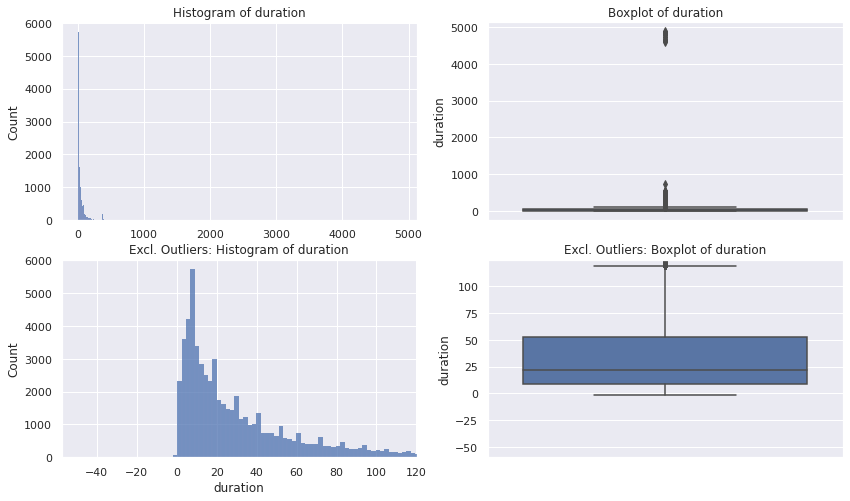

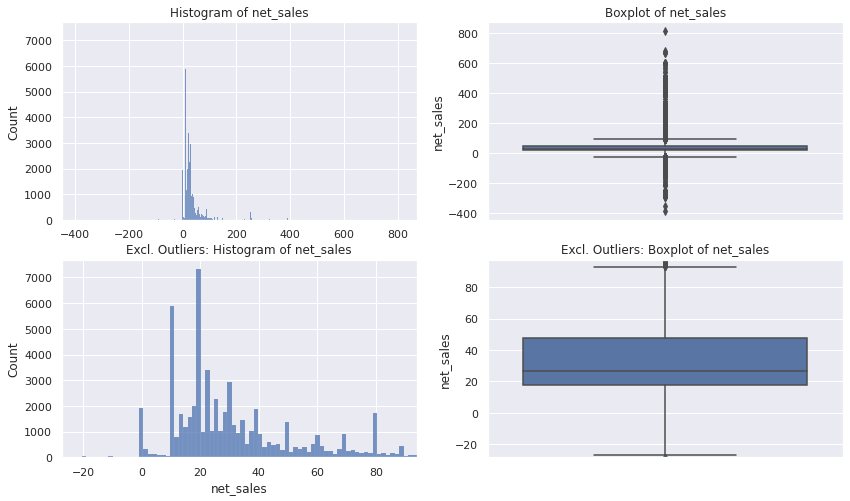

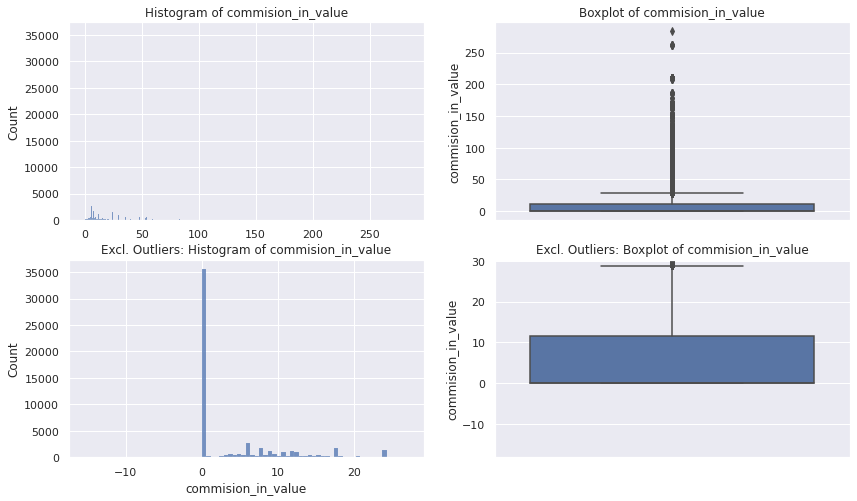

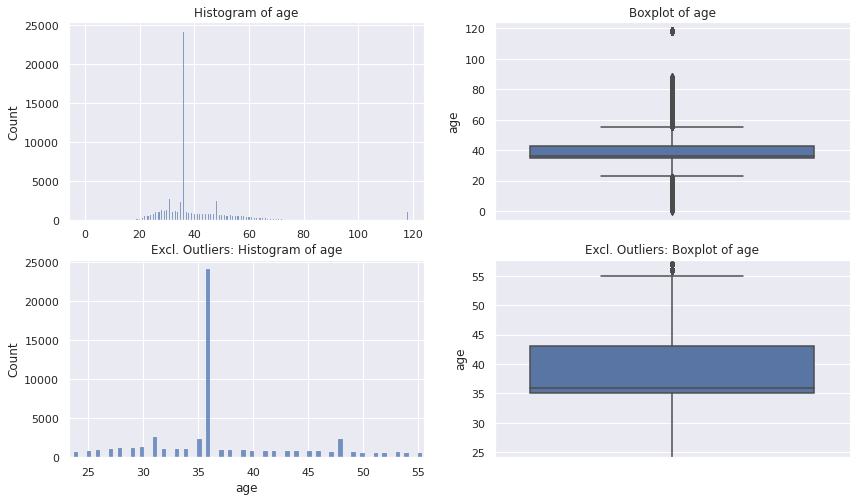

In [71]:
for i in numerical_feature_list:
    numerical_feature_analysis(i)

In [94]:
# Function for creating count plot and the corresponding percentage distribution plots for categorical variables
# Count plot is to help in understanding the distribution of the feature
# % distribution plot helps us to see the % distribution of different categories for a feature.
def categorical_feature_plot(feature):
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,6))
    df[feature].value_counts()[:10].plot(kind='bar',ax=ax[0],rot=90,title="Counts of "+feature)
    ax[0].set_xlabel(feature)
    #sns.countplot(df[feature],ax=ax[0],order=df[feature].unique())
    #ax[0].set_title("Counts of "+feature)
    #ax[0].set_xticklabels(df[feature].unique(), rotation=90)
    df[feature].value_counts(normalize=True)[:10].plot(kind='bar',ax=ax[1])
    ax[1].set_title("Distribution of "+feature)
    ax[1].set_xlabel(feature)
    ax[1].set_ylabel("% Distribution")
    ax[1].set_xticklabels(df[feature].value_counts(normalize=True).index[:10], rotation=90)

Feature:agency

No. of unique values:16

Distribution: 

EPX    0.554575
CWT    0.135489
C2B    0.130547
JZI    0.099943
SSI    0.016676
JWT    0.011828
RAB    0.011449
LWC    0.010880
TST    0.008338
KML    0.006190
ART    0.005227
CCR    0.003064
CBH    0.001595
TTW    0.001548
CSR    0.001358
ADM    0.001295
Name: agency, dtype: float64
------------------------------------------
Feature:agency_type

No. of unique values:2

Distribution: 

Travel Agency    0.724331
Airlines         0.275669
Name: agency_type, dtype: float64
------------------------------------------
Feature:distribution_channel

No. of unique values:2

Distribution: 

Online     0.982519
Offline    0.017481
Name: distribution_channel, dtype: float64
------------------------------------------
Feature:product_name

No. of unique values:26

Distribution: 

Cancellation Plan                    0.294192
2 way Comprehensive Plan             0.207782
Rental Vehicle Excess Insurance      0.135489
Basic Plan                  

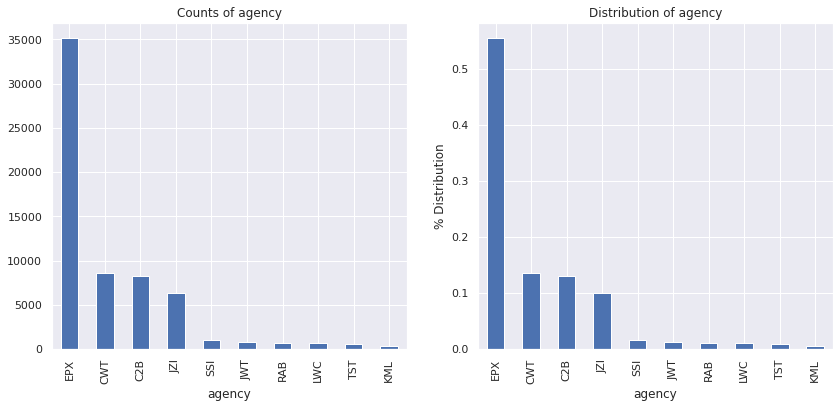

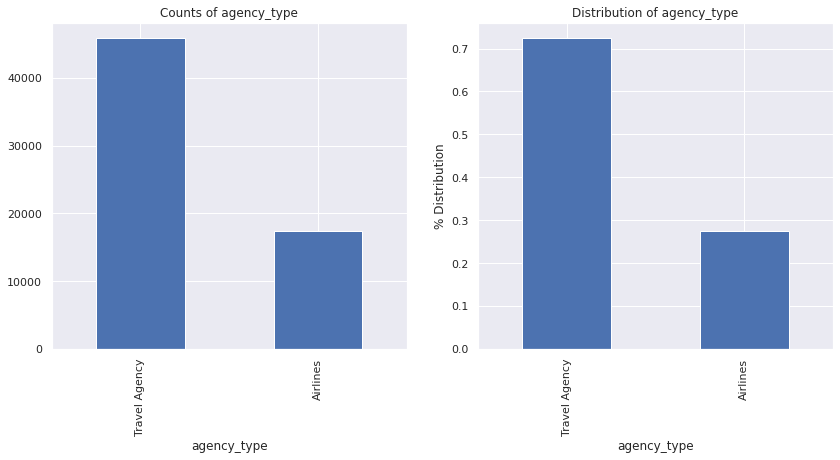

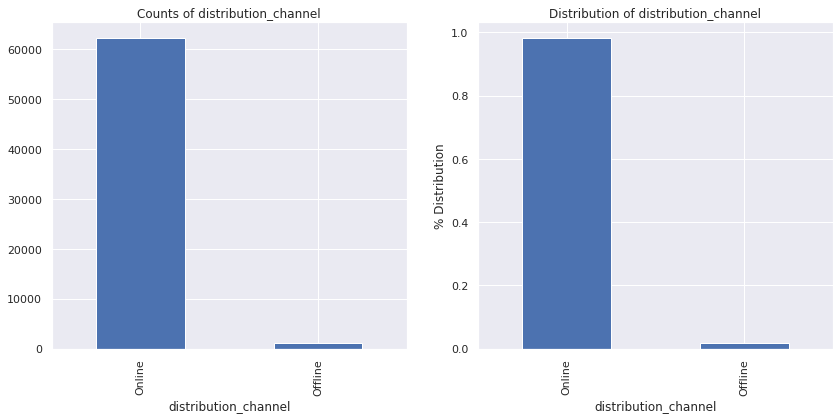

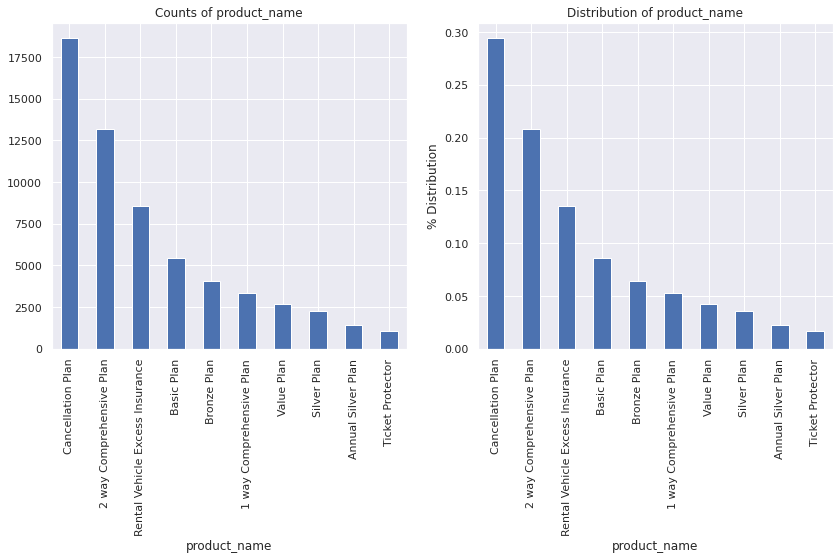

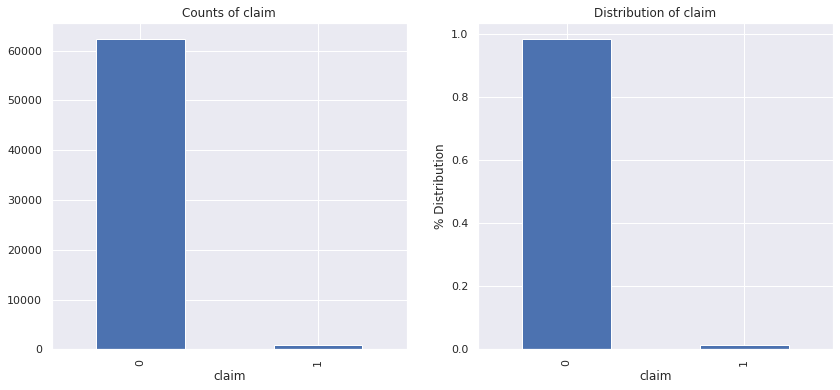

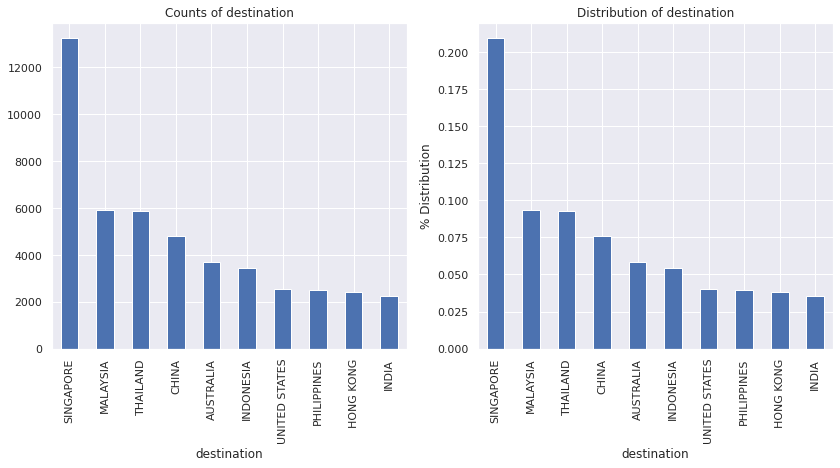

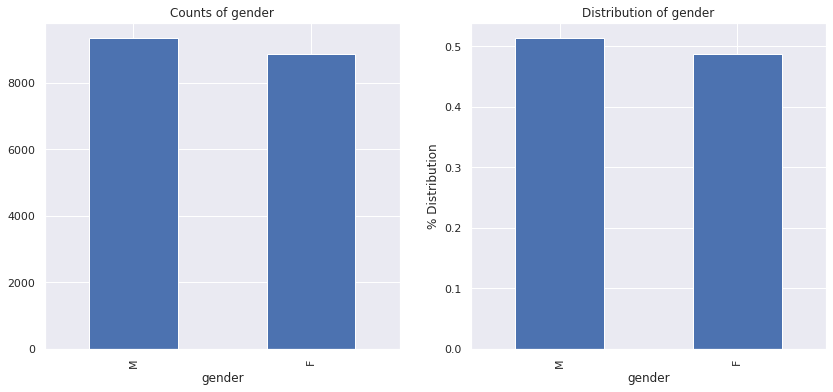

In [95]:
# Plotting for all categorical features
for i in categorical_feature_list:
    categorical_feature_plot(i)
    print("Feature:"+i+'\n')
    print("No. of unique values:"+ str(df[i].nunique())+"\n")
    print("Distribution: \n")
    print(df[i].value_counts(normalize=True).head(20))
    print("------------------------------------------")

In [14]:
df[df['duration']==0].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
agency,61,8,JWT,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency_type,61,2,Airlines,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distribution_channel,61,2,Online,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,61,8,Value Plan,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
claim,61,1,No,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,61,NaN,NaN,NaN,0,0,0,0,0,0,0
destination,61,10,INDIA,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
net_sales,61,NaN,NaN,NaN,23.7448,23.7012,-14.4,9.77,18,31,124
commision_in_value,61,NaN,NaN,NaN,9.53082,9.63885,0,3.6,6.3,12.4,49.6
gender,38,2,M,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Not able to deduce further

In [12]:
df[df['duration']<0].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
agency,5,1,JZI,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency_type,5,1,Airlines,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distribution_channel,5,1,Online,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,5,1,Basic Plan,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
claim,5,1,No,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,5,NaN,NaN,NaN,-1.2,0.447214,-2,-1,-1,-1,-1
destination,5,5,BANGLADESH,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
net_sales,5,NaN,NaN,NaN,19.6,2.19089,18,18,18,22,22
commision_in_value,5,NaN,NaN,NaN,6.86,0.766812,6.3,6.3,6.3,7.7,7.7
gender,1,1,M,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As per above data, below are some observations:

*   All 5 negative values are coming from single agency JZI (Online).
*   All have taken same product.
*   All 5 customers have same age-118.

So considering these, it feels OK to turn them to +ve values. Lets change it for now. But this need to be discussed with business whether there can be -ve values or not.







In [16]:
df[df['net_sales']<=0]

,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision_in_value,gender,age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41
...,...,...,...,...,...,...,...,...,...,...,...
62806,C2B,Airlines,Online,Bronze Plan,No,12,SINGAPORE,0.0,6.63,F,24
62833,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,165,AUSTRALIA,0.0,29.70,NaN,26
62993,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,5,MALAYSIA,0.0,17.82,NaN,53
62996,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,3,MALAYSIA,0.0,17.82,NaN,49


By observing the data, it seems all these -ve values should be turned into positives. But its better not to touch them as we dont know the business context and the volume is also significant. Lets leave it as it is for now and proceed further.

In [38]:
df[df['duration'].between(120,400)]

,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision_in_value,gender,age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.00,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.00,9.57,F,71
9,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,186,AUSTRALIA,-99.00,59.40,NaN,37
20,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,136,NORWAY,-108.90,65.34,NaN,32
24,C2B,Airlines,Online,Silver Plan,No,190,SINGAPORE,294.75,73.69,M,26
...,...,...,...,...,...,...,...,...,...,...,...
63252,EPX,Travel Agency,Online,2 way Comprehensive Plan,No,121,THAILAND,20.00,0.00,NaN,59
63255,EPX,Travel Agency,Online,2 way Comprehensive Plan,No,159,INDONESIA,20.00,0.00,NaN,42
63285,EPX,Travel Agency,Online,Cancellation Plan,No,146,PHILIPPINES,20.00,0.00,NaN,35
63286,EPX,Travel Agency,Online,Cancellation Plan,No,147,UNITED STATES,79.00,0.00,NaN,28


In [46]:
df[df['duration']>300]['product_name'].value_counts()

Cancellation Plan                       18630
2 way Comprehensive Plan                13158
Rental Vehicle Excess Insurance          8580
Basic Plan                               5469
Bronze Plan                              4049
1 way Comprehensive Plan                 3331
Value Plan                               2715
Silver Plan                              2249
Annual Silver Plan                       1423
Ticket Protector                         1056
Travel Cruise Protect                     527
Comprehensive Plan                        364
Gold Plan                                 352
24 Protect                                247
Single Trip Travel Protect Gold           204
Premier Plan                              194
Annual Gold Plan                          194
Single Trip Travel Protect Silver         173
Annual Travel Protect Gold                100
Annual Travel Protect Silver               86
Individual Comprehensive Plan              74
Single Trip Travel Protect Platinu

By looking at the product_name, Annual Gold Plan seems to contain all the features of Annual Silver Plan and some additional benefits. But by looking at the purchase counts, its clear that customers are not attracted to those additional benefits and hence they are buying only Annual Silver Plan. Probably business can do further research on it and can either decrease the Annual Gold Plan Price or increase/change the benefits.

In [57]:
df[df['duration']>750]['product_name'].value_counts()

Ticket Protector    14
Name: product_name, dtype: int64

Customers who are taking insurance for more than 10 years are opting for Ticket Protector Product.

In [58]:
np.sort(df['destination'].unique())

array(['ALBANIA', 'ANGOLA', 'ARGENTINA', 'ARMENIA', 'AUSTRALIA',
       'AUSTRIA', 'AZERBAIJAN', 'BAHRAIN', 'BANGLADESH', 'BARBADOS',
       'BELARUS', 'BELGIUM', 'BENIN', 'BERMUDA', 'BHUTAN', 'BOLIVIA',
       'BOSNIA AND HERZEGOVINA', 'BOTSWANA', 'BRAZIL',
       'BRUNEI DARUSSALAM', 'BULGARIA', 'CAMBODIA', 'CAMEROON', 'CANADA',
       'CAYMAN ISLANDS', 'CHILE', 'CHINA', 'COLOMBIA', 'COSTA RICA',
       'CROATIA', 'CYPRUS', 'CZECH REPUBLIC', 'DENMARK',
       'DOMINICAN REPUBLIC', 'ECUADOR', 'EGYPT', 'ESTONIA', 'ETHIOPIA',
       'FAROE ISLANDS', 'FIJI', 'FINLAND', 'FRANCE', 'FRENCH POLYNESIA',
       'GEORGIA', 'GERMANY', 'GHANA', 'GREECE', 'GUADELOUPE', 'GUAM',
       'GUATEMALA', 'GUINEA', 'GUINEA-BISSAU', 'GUYANA', 'HONG KONG',
       'HUNGARY', 'ICELAND', 'INDIA', 'INDONESIA',
       'IRAN, ISLAMIC REPUBLIC OF', 'IRELAND', 'ISRAEL', 'ITALY',
       'JAMAICA', 'JAPAN', 'JORDAN', 'KAZAKHSTAN', 'KENYA',
       "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF", 'KOREA, REPUBLIC OF',
       '

##### Multivariate Analysis

In [8]:
# Before starting analyis, its better to encode Target feature from YES/NO to 1/0
# This would help in doing the analysis better.

df['claim']=df['claim'].map({'Yes':1,'No':0})

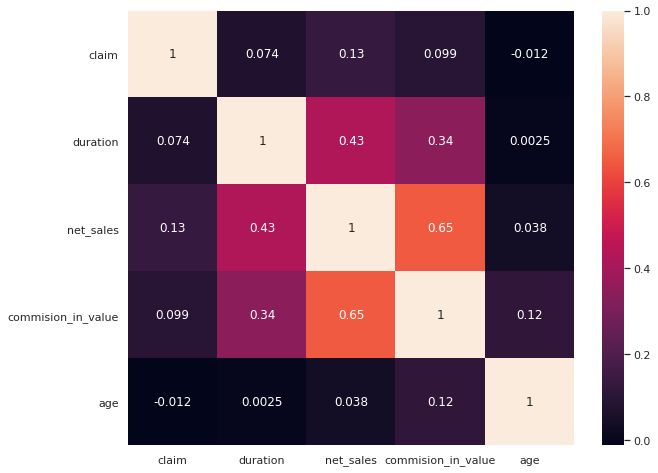

In [75]:
# For continuous variables, Correlation with Heatmap serves as starting point
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)

In [10]:
target='claim'

In [100]:
def feature_target_plot(feature):
    #plt.figure(figsize=(12,12))
    nbins=df[feature]
    if feature in numerical_feature_list:
        g=sns.FacetGrid(data=df,col=target,height=5, aspect =1.5)
        g.map(plt.hist,feature)
        g.set_xticklabels(rotation=90)
    else:
        g=sns.FacetGrid(data=df,col=target,height=5, aspect =1.5)
        g.map(sns.countplot,feature,order=df[feature].value_counts().index[:10])
        g.set_xticklabels(rotation=90)
    

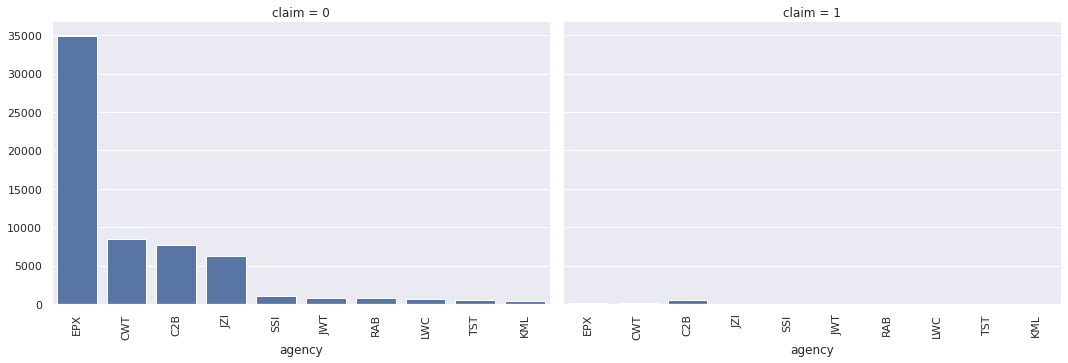

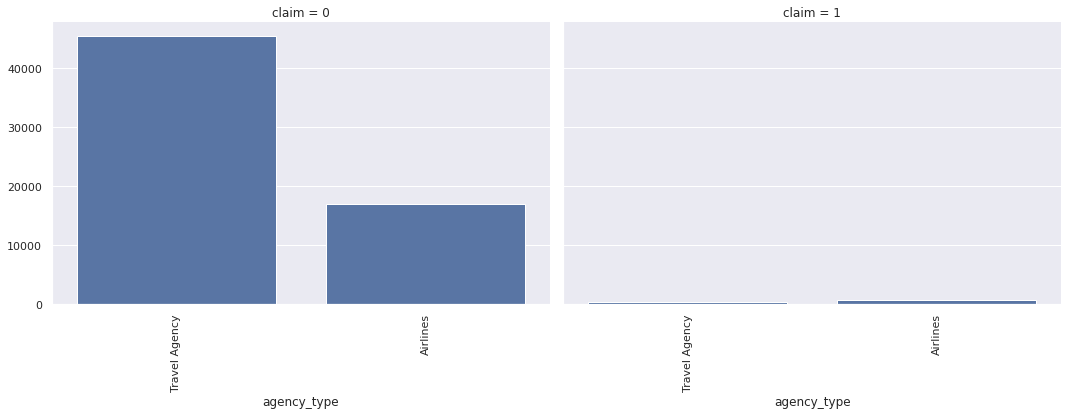

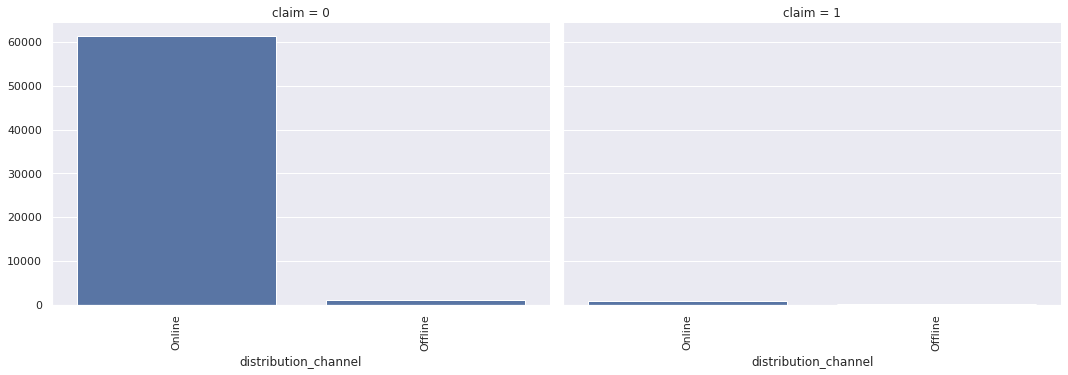

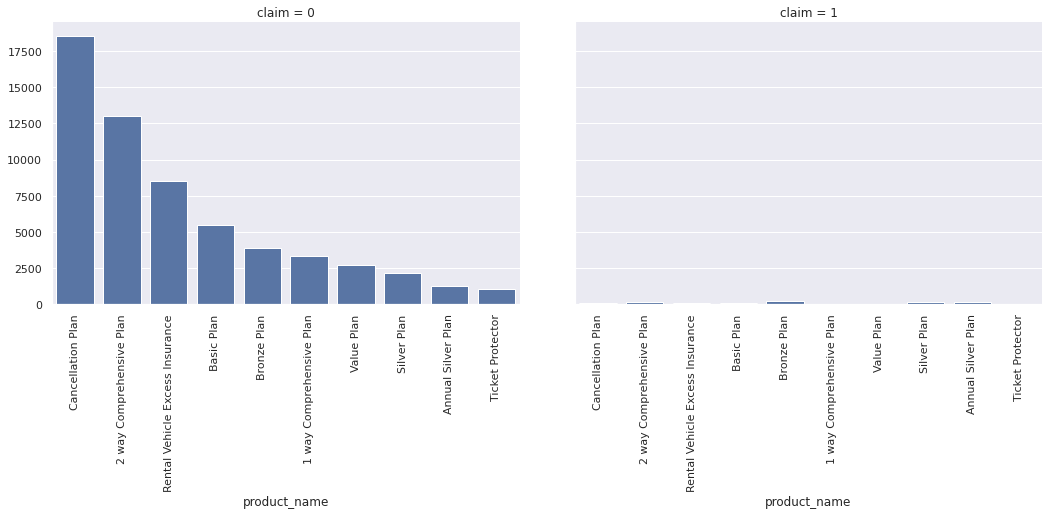

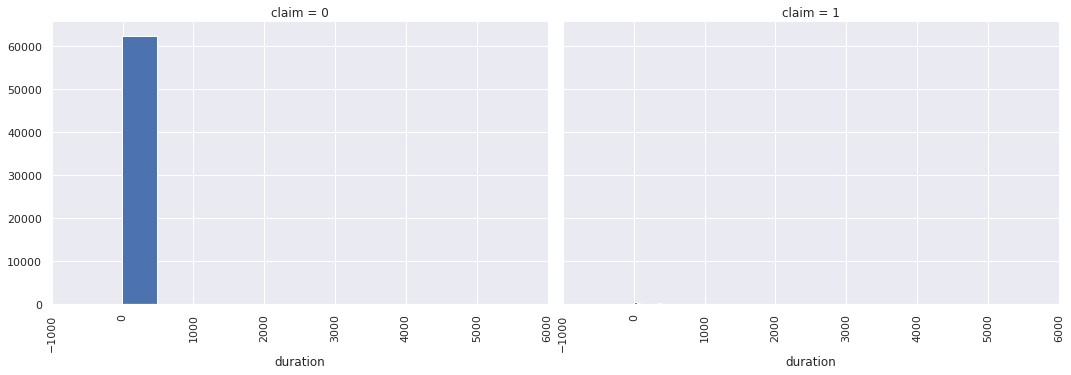

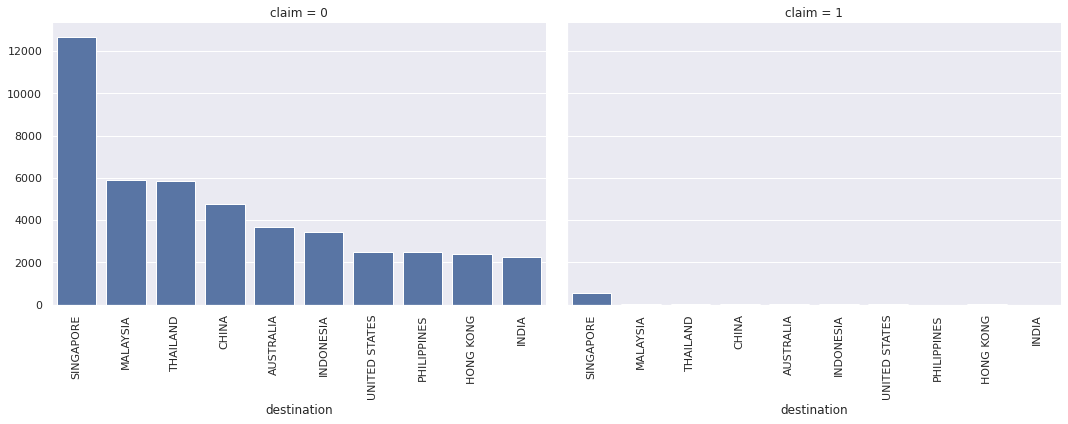

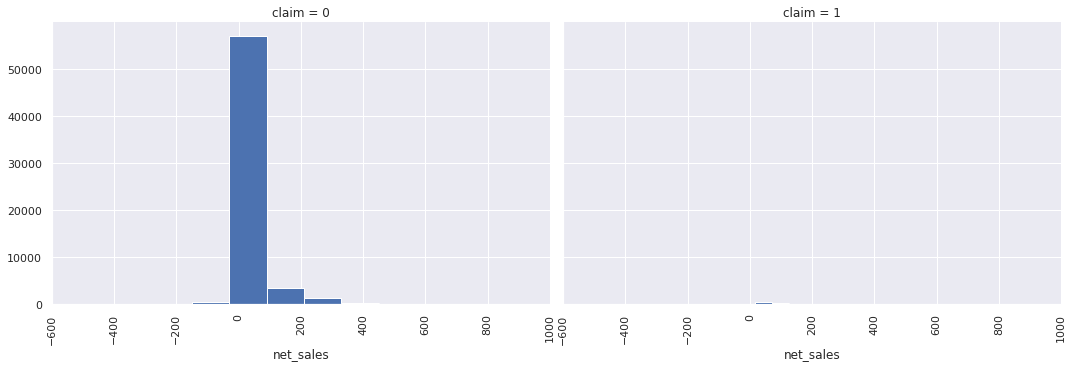

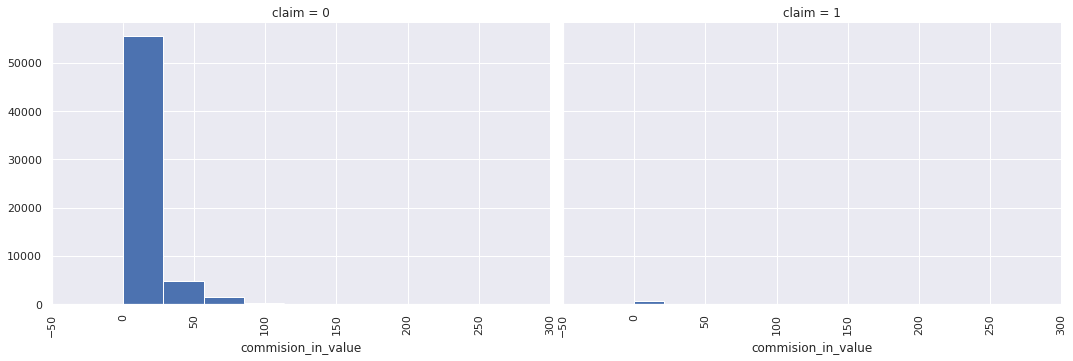

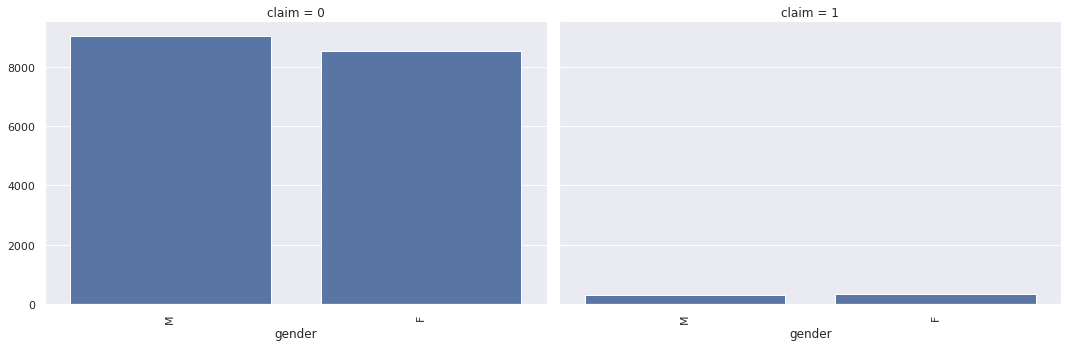

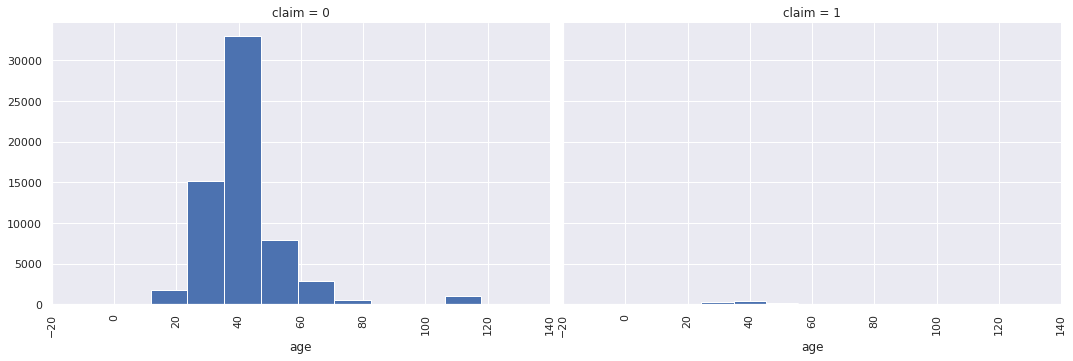

In [101]:
for i in df.columns:
    if i!=target:
        feature_target_plot(i)

In [114]:
def feature_target_analysis(feature,count):
    if feature!=target:
        plt.figure(count,figsize=(8,6))
        if i in numerical_feature_list:
            nbins=(df[feature].max()-abs(df[feature].min()))/(np.std(df[feature]))
            new_feature=feature+'_Band'
            df[new_feature]=pd.qcut(x=df[feature],q=4,duplicates='drop')
            feature=new_feature
            feature_band_list.append(new_feature)
            sns.pointplot(x=feature,y=target,data=df[[target,feature]].groupby(by=feature,as_index=False).mean().sort_values(by=target,ascending=False)[:15])
            plt.xticks(rotation=90)
        else:
            sns.pointplot(x=feature,y=target,data=df[[target,feature]].groupby(by=feature,as_index=False).mean().sort_values(by=target,ascending=False)[:15])
            plt.xticks(rotation=90)

In [115]:
df[[target,'agency']].groupby(by='agency',as_index=False).mean().sort_values(by='claim',ascending=False)[:10]

,agency,claim
2,C2B,0.066167
11,LWC,0.052250
15,TTW,0.040816
10,KML,0.020408
4,CCR,0.015464
5,CSR,0.011628
6,CWT,0.010023
3,CBH,0.009901
13,SSI,0.006629
7,EPX,0.005553


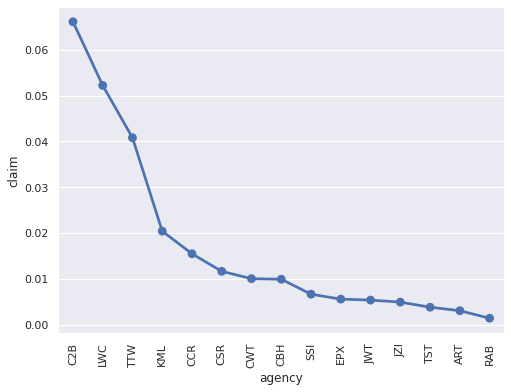

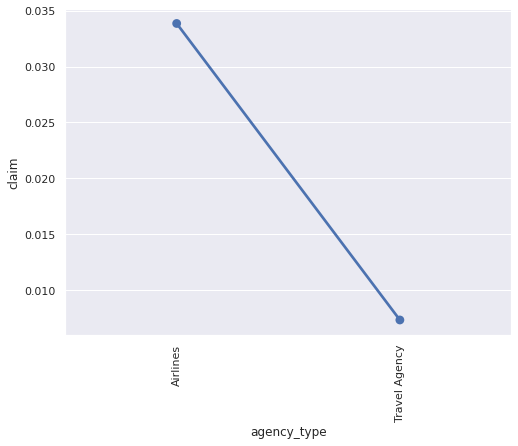

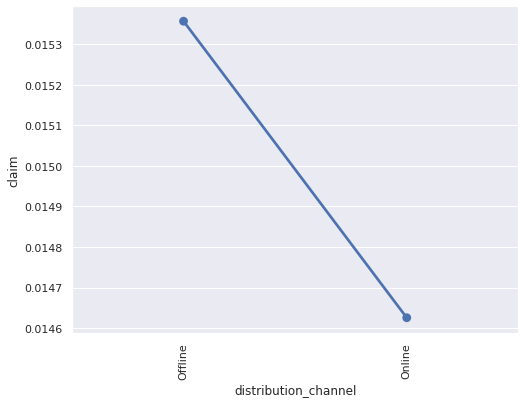

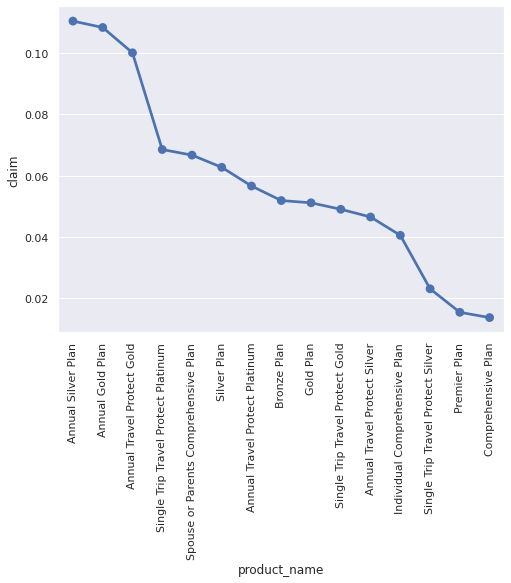

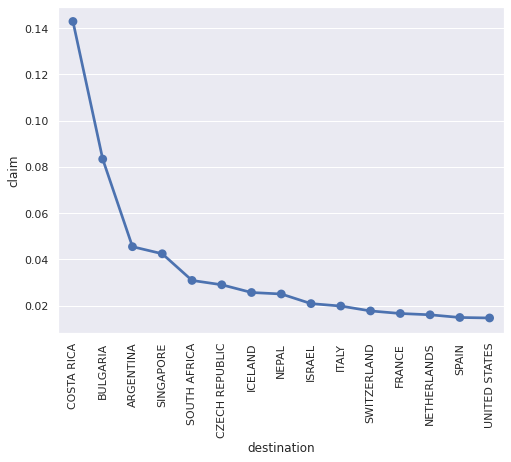

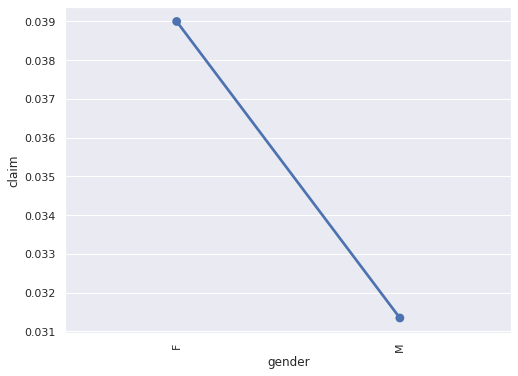

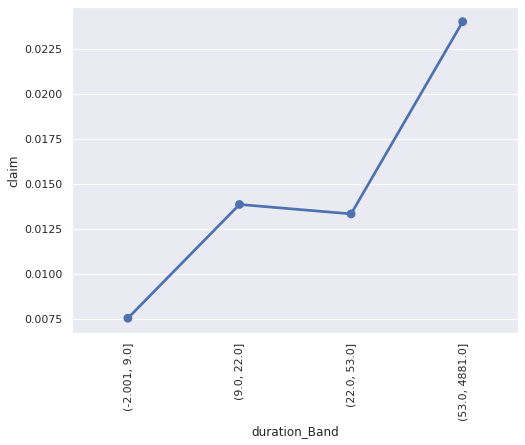

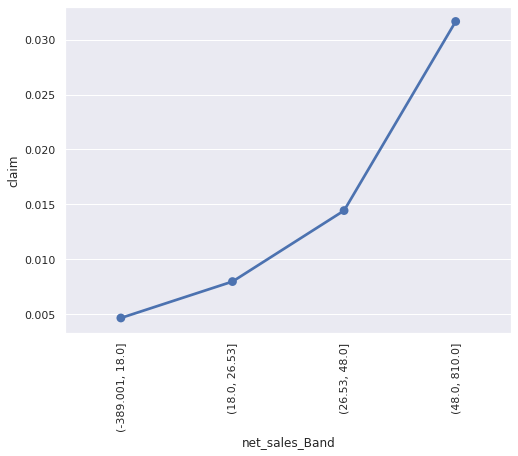

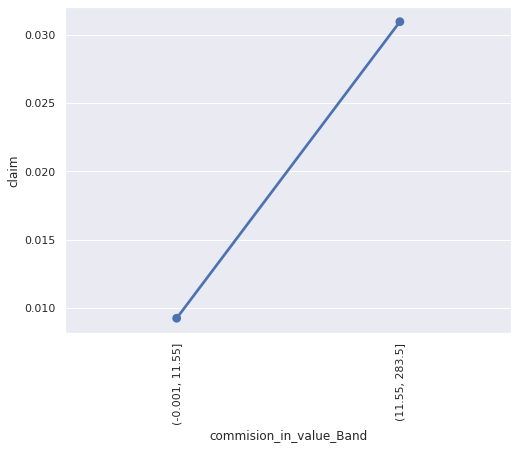

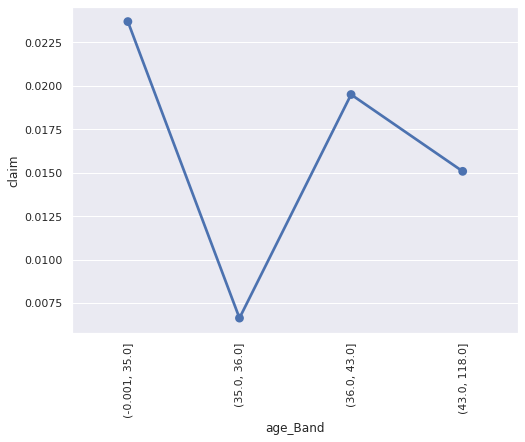

In [116]:
feature_band_list=[]
count=0
for i in categorical_feature_list+numerical_feature_list:
    count=count+1
    feature_target_analysis(i,count)

In [182]:
feature_band_list

['duration_Band', 'net_sales_Band', 'commision_in_value_Band', 'age_Band']

In [183]:
# Removing the Band features created for analysis and understanding of data
df.drop(feature_band_list,inplace=True,axis=1)

In [119]:
df[df['claim']==1].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
agency,927,15,C2B,547,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency_type,927,2,Airlines,591,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distribution_channel,927,2,Online,910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,927,23,Bronze Plan,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
claim,927,NaN,NaN,NaN,1,0,1,1,1,1,1
duration,927,NaN,NaN,NaN,110.789,141.375,1,15,38,120,431
destination,927,41,SINGAPORE,562,NaN,NaN,NaN,NaN,NaN,NaN,NaN
net_sales,927,NaN,NaN,NaN,94.3744,93.1749,-37,29,53.25,118.8,507
commision_in_value,927,NaN,NaN,NaN,25.8464,32.4823,0,4.25,12.25,46.96,210.21
gender,639,2,F,346,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observations:



agency:

In [31]:
df['age_bin'].value_counts()

2    32618
3    13363
0    11772
1     5573
Name: age_bin, dtype: int64

In [61]:
df[df['claim']=='Yes']['agency'].value_counts()

C2B    547
EPX    195
CWT     86
LWC     36
JZI     31
KML      8
SSI      7
JWT      4
TTW      4
CCR      3
TST      2
ART      1
RAB      1
CBH      1
CSR      1
Name: agency, dtype: int64

In [64]:
df[df['agency']=='C2B'][['agency','product_name','claim']].groupby(by=['claim','product_name']).count()

agency
claim product_name              
No    Annual Gold Plan       173
      Annual Silver Plan    1266
      Bronze Plan           3839
      Gold Plan              334
      Silver Plan           2108
Yes   Annual Gold Plan        21
      Annual Silver Plan     157
      Bronze Plan            210
      Gold Plan               18
      Silver Plan            141

In [70]:
df[df['product_name']=='Annual Gold Plan']['agency'].unique()

array(['C2B'], dtype=object)

In [73]:
df[(df['agency']=='EPX') & (df['claim']=='Yes')]['product_name'].value_counts()

2 way Comprehensive Plan    142
Cancellation Plan            44
1 way Comprehensive Plan      9
Name: product_name, dtype: int64

In [25]:
numerical_feature_list

['duration', 'net_sales', 'commision_in_value', 'age']

In [184]:
df

,agency,agency_type,distribution_channel,product_name,claim,duration,destination,net_sales,commision_in_value,gender,age,agency_fe,agency_type_fe,distribution_channel_fe,product_name_fe,destination_fe,gender_fe,agency_agency_type,agency_distribution_channel,agency_product_name,agency_destination,agency_gender,agency_type_distribution_channel,agency_type_product_name,agency_type_destination,agency_type_gender,distribution_channel_product_name,distribution_channel_destination,distribution_channel_gender,product_name_destination,product_name_gender,destination_gender,agency_agency_type_nunique,agency_agency_type_count,agency_distribution_channel_nunique,agency_distribution_channel_count,agency_product_name_nunique,agency_product_name_count,agency_destination_nunique,agency_destination_count,...,destination_commision_in_value_mean,destination_commision_in_value_median,destination_commision_in_value_max,destination_commision_in_value_min,destination_commision_in_value_std,destination_age_mean,destination_age_median,destination_age_max,destination_age_min,destination_age_std,gender_agency_nunique,gender_agency_count,gender_agency_type_nunique,gender_agency_type_count,gender_distribution_channel_nunique,gender_distribution_channel_count,gender_product_name_nunique,gender_product_name_count,gender_destination_nunique,gender_destination_count,gender_duration_mean,gender_duration_median,gender_duration_max,gender_duration_min,gender_duration_std,gender_net_sales_mean,gender_net_sales_median,gender_net_sales_max,gender_net_sales_min,gender_net_sales_std,gender_commision_in_value_mean,gender_commision_in_value_median,gender_commision_in_value_max,gender_commision_in_value_min,gender_commision_in_value_std,gender_age_mean,gender_age_median,gender_age_max,gender_age_min,gender_age_std
0,CBH,Travel Agency,Offline,Comprehensive Plan,0,186,MALAYSIA,-29.0,9.57,F,81,0.001595,0.724331,0.017481,0.005748,0.093642,0.140100,0.001595,0.001595,0.001563,0.000758,0.001121,0.017165,0.005748,0.083583,0.019565,0.005748,0.006885,0.010249,0.002779,0.004248,0.008148,1,101,1,101,2,101,3,101,...,6.299808,0.00,112.86,0.0,9.228722,41.169140,36.0,118,1,13.351580,14,8872,2,8872,2,8872,21,8872,61,8872,75.223399,25,740,0,116.024762,59.211846,30.0,810.0,-291.75,75.083493,18.754108,10.50,283.50,0.0,24.874254,42.940825,38,118,0,19.427193
1,CBH,Travel Agency,Offline,Comprehensive Plan,0,186,MALAYSIA,-29.0,9.57,F,71,0.001595,0.724331,0.017481,0.005748,0.093642,0.140100,0.001595,0.001595,0.001563,0.000758,0.001121,0.017165,0.005748,0.083583,0.019565,0.005748,0.006885,0.010249,0.002779,0.004248,0.008148,1,101,1,101,2,101,3,101,...,6.299808,0.00,112.86,0.0,9.228722,41.169140,36.0,118,1,13.351580,14,8872,2,8872,2,8872,21,8872,61,8872,75.223399,25,740,0,116.024762,59.211846,30.0,810.0,-291.75,75.083493,18.754108,10.50,283.50,0.0,24.874254,42.940825,38,118,0,19.427193
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,65,AUSTRALIA,-49.5,29.70,X,32,0.135489,0.724331,0.982519,0.135489,0.058333,0.712298,0.135489,0.135379,0.135489,0.039605,0.135410,0.707166,0.135489,0.055112,0.690806,0.135379,0.057954,0.710814,0.039605,0.135410,0.054433,1,8580,2,8580,1,8580,74,8580,...,26.066960,23.76,178.20,0.0,22.577157,39.432052,36.0,118,16,10.205238,10,45107,2,45107,2,45107,11,45107,143,45107,41.484758,23,4881,-1,95.802964,33.921695,24.0,306.9,-297.00,31.384008,6.307947,0.00,184.14,0.0,16.009914,38.024985,36,118,7,9.292921
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0,60,AUSTRALIA,-39.6,23.76,X,32,0.135489,0.724331,0.982519,0.135489,0.058333,0.712298,0.135489,0.135379,0.135489,0.039605,0.135410,0.707166,0.135489,0.055112,0.690806,0.135379,0.057954,0.710814,0.039605,0.135410,0.054433,1,8580,2,8580,1,8580,74,8580,...,26.066960,23.76,178.20,0.0,22.577157,39.432052,36.0,118,16,10.205238,10,45107,2,45107,2,45107,11,45107,143,45107,41.484758,23,4881,-1,95.802964,33.921695,24.0,306.9,-297.00,31.384008,6.307947,0.00,184.14,0.0,16.009914,38.024985,36,118,7,9.292921
4,CWT,Travel A

###### agency vs agency_type:

In [226]:
df['agency_type'].nunique()

2

In [227]:
df['agency_agency_type_nunique'].value_counts()

1    63326
Name: agency_agency_type_nunique, dtype: int64

Agency Type for each Agency is either Travel Agency or Airline but not both.

In [78]:
df[['agency_type','claim']].groupby(by='agency_type').agg({'claim':['count','sum','mean']})

claim               
               count  sum      mean
agency_type                        
Airlines       17457  591  0.033855
Travel Agency  45869  336  0.007325

In [73]:
df[['agency','agency_type','claim',]].groupby(by=['agency','agency_type']).agg({'claim':['count','sum','mean']})

claim               
                      count  sum      mean
agency agency_type                        
ADM    Travel Agency     82    0  0.000000
ART    Airlines         331    1  0.003021
C2B    Airlines        8267  547  0.066167
CBH    Travel Agency    101    1  0.009901
CCR    Travel Agency    194    3  0.015464
CSR    Travel Agency     86    1  0.011628
CWT    Travel Agency   8580   86  0.010023
EPX    Travel Agency  35119  195  0.005553
JWT    Airlines         749    4  0.005340
JZI    Airlines        6329   31  0.004898
KML    Travel Agency    392    8  0.020408
LWC    Travel Agency    689   36  0.052250
RAB    Airlines         725    1  0.001379
SSI    Airlines        1056    7  0.006629
TST    Travel Agency    528    2  0.003788
TTW    Travel Agency     98    4  0.040816

*   6.6% of insurances are claimed when taken through C2B(Airline)
*   Rest other airlines are having lower claim ratio.
*   Claims through LWC and TTM are around 5% and 4% respectively. Though the volumes are less right now, this need to be monitored.





###### agency vs distribution_channel:

In [228]:
df['distribution_channel'].nunique()

2

In [229]:
df['agency_distribution_channel_nunique'].value_counts()

2    52532
1    10794
Name: agency_distribution_channel_nunique, dtype: int64

In [232]:
df[df['agency_distribution_channel_nunique']==1]['agency'].nunique()

9

In [233]:
df[df['agency_distribution_channel_nunique']==1]['distribution_channel'].unique()

array(['Offline', 'Online'], dtype=object)

Out of 26 agencies, only 9 agencies are having only either Online or Offline servies. Rest other 17 agencies have both servies.

In [81]:
df[df['claim']==1]['distribution_channel'].agg()

Online     910
Offline     17
Name: distribution_channel, dtype: int64

###### agency vs product_name:

In [221]:
df['product_name'].nunique()

26

In [222]:
df['agency_product_name_nunique'].value_counts()

3    41546
1    11110
5     8267
2     1714
6      689
Name: agency_product_name_nunique, dtype: int64

In [217]:
def is_agency_cross_product_sell():
    cross_products=dict()
    for i in df['product_name'].unique():
       if df[df['product_name']==i]['agency'].nunique()>1:
         cross_products[i]= list(df[df['product_name']==i]['agency'].unique())
    return cross_products


In [218]:
is_agency_cross_product_sell()

{'Comprehensive Plan': ['CBH', 'CSR', 'CCR'],
 'Premier Plan': ['KML', 'CCR', 'ADM', 'CSR', 'JZI', 'CBH'],
 'Value Plan': ['JZI', 'JWT', 'RAB', 'KML', 'ART', 'ADM']}

Observations:

*   Each Agency sells upto a max of 6 products out of total 26 products. Majority agencies sell only 3 products.
*   Out of 26 products, only 3 products are sold across by multiple agencies.



###### agency vs duration:

In [ ]:
df['duration_bins'].nunique()

2

In [21]:
df[['agency','agency_fe','agency_duration_mean','agency_duration_median','agency_duration_min','agency_duration_max','agency_duration_std']].groupby(by='agency').min()

,agency_fe,agency_duration_mean,agency_duration_median,agency_duration_min,agency_duration_max,agency_duration_std
agency,,,,,,
ADM,0.001295,54.914634,41.5,3,197,46.145289
ART,0.005227,30.359517,14.0,1,351,44.286540
C2B,0.130547,95.219910,21.0,0,740,141.949984
CBH,0.001595,91.950495,64.0,5,277,74.235891
CCR,0.003064,62.809278,45.0,2,282,67.289181
CSR,0.001358,79.895349,58.0,5,242,62.636961
CWT,0.135489,41.450350,24.0,0,430,47.352372
EPX,0.554575,39.158860,22.0,0,330,46.991933
JWT,0.011828,29.371162,16.0,0,268,35.244615




*   All Products sold by TTW Agency are taken for around a year.
*   Products sold by SSI are having higher variation in duration. Thats probably because of Ticket Protector Product taken by some customers for more than 10 years.
*   Products sold by C2B are also having higher variation and its because of Annual Silver Plan which is taken for higher durations.





###### agency vs destination:

In [56]:
df['destination'].nunique()

149

In [64]:
df[['agency','agency_destination','agency_destination_nunique','agency_destination_count']].groupby(by='agency').max()

,agency_destination,agency_destination_nunique,agency_destination_count
agency,,,
ADM,0.000821,13,82
ART,0.001627,23,331
C2B,0.130547,1,8267
CBH,0.000805,3,101
CCR,0.001737,3,194
CSR,0.000790,4,86
CWT,0.039605,74,8580
EPX,0.059486,138,35119
JWT,0.011828,1,749


*   C2B Agency booked insurance for customers going to singapore only.




###### agency vs net_sales:

In [26]:
[i for i in df.columns if 'agency_net_sales' in i]

['agency_net_sales_mean',
 'agency_net_sales_median',
 'agency_net_sales_max',
 'agency_net_sales_min',
 'agency_net_sales_std']

In [ ]:
[i for i in df.columns if 'claim' in i]

In [232]:
df[['agency','agency_fe','agency_claim_mean']+[i for i in df.columns if 'agency_net_sales' in i]].groupby(by='agency').min()

,agency_fe,agency_claim_mean,agency_net_sales_mean,agency_net_sales_median,agency_net_sales_max,agency_net_sales_min,agency_net_sales_std
agency,,,,,,,
ADM,0.001295,0.000000,53.256098,75.00,279.00,-147.00,82.272029
ART,0.005227,0.003021,28.691601,23.00,184.42,-28.50,27.858259
C2B,0.130547,0.066167,78.865811,35.50,682.00,-389.00,93.907935
CBH,0.001595,0.009901,27.168317,29.00,76.00,-29.00,11.680813
CCR,0.003064,0.015464,30.654639,29.00,76.00,0.00,9.109541
CSR,0.001358,0.011628,32.802326,29.00,153.00,29.00,19.290851
CWT,0.135489,0.010023,43.040769,39.60,306.90,-297.00,44.500588
EPX,0.554575,0.005553,32.564993,22.00,192.00,-128.00,26.755535
JWT,0.011828,0.005340,53.012016,39.00,420.00,-93.00,40.215909



*   Claims seem to be higher for agencies which have Average net sales mean
*   net_sales in TTW agency is high and consistent with mean and median very close.
*   But these stats will significantly vary if -ve values are turned out to be +ves.





###### agency vs commision_in_value:

In [32]:
df[['agency','agency_fe']+[i for i in df.columns if 'agency_commision_in_value' in i]].groupby(by='agency').min()

,agency_fe,agency_commision_in_value_mean,agency_commision_in_value_median,agency_commision_in_value_max,agency_commision_in_value_min,agency_commision_in_value_std
agency,,,,,,
ADM,0.001295,38.254878,34.390,106.02,10.64,15.401455
ART,0.005227,10.553927,8.490,64.55,0.44,9.442703
C2B,0.130547,20.533124,9.750,170.50,2.88,23.324790
CBH,0.001595,10.030693,9.570,25.08,9.57,2.386555
CCR,0.003064,10.313351,9.570,25.08,9.57,2.623558
CSR,0.001358,10.824767,9.570,50.49,9.57,6.365981
CWT,0.135489,32.380615,23.760,184.14,5.94,22.141890
EPX,0.554575,0.000000,0.000,0.00,0.00,0.000000
JWT,0.011828,21.640053,15.600,168.00,12.40,15.562216


*   EPX agency sells more than 50% of total insurances.
The probable reason being the commission value is Zero indicating that EPX sells insurance without taking any commission.
May be thats the reason, insurance company has given authorization to sell 2 most sold products to EPX
*   Even TTW is providing insurance with zero comission.



###### agency vs gender:

In [38]:
df['agency_gender_nunique'].value_counts()

1    36175
3    17518
2     9633
Name: agency_gender_nunique, dtype: int64

In [42]:
df['gender'].unique()

array(['F', 'X', 'M'], dtype=object)

In [51]:
df[['agency','gender','product_name']].groupby(by=['agency','gender']).count()

product_name
agency gender              
ADM    F                 16
       M                 17
       X                 49
ART    F                 96
       M                230
       X                  5
C2B    F               4594
       M               3673
CBH    F                 71
       M                 30
CCR    F                143
       M                 50
       X                  1
CSR    F                 64
       M                 22
CWT    F                  3
       M                  2
       X               8575
EPX    X              35119
JWT    F                238
       M                494
       X                 17
JZI    F               2560
       M               3706
       X                 63
KML    F                192
       M                200
LWC    F                382
       M                307
RAB    F                145
       M                360
       X                220
SSI    X               1056
TST    F                319
       M                207
       X                  2
TTW    F                 49
       M                 49

In [53]:
df.groupby(by=['agency','claim'])['product_name'].count()

agency  claim
ADM     0           82
ART     0          330
        1            1
C2B     0         7720
        1          547
CBH     0          100
        1            1
CCR     0          191
        1            3
CSR     0           85
        1            1
CWT     0         8494
        1           86
EPX     0        34924
        1          195
JWT     0          745
        1            4
JZI     0         6298
        1           31
KML     0          384
        1            8
LWC     0          653
        1           36
RAB     0          724
        1            1
SSI     0         1049
        1            7
TST     0          526
        1            2
TTW     0           94
        1            4
Name: product_name, dtype: int64

###### agency vs age:

In [55]:
df[['agency','agency_fe']+[i for i in df.columns if 'agency_age_' in i]].groupby(by='agency').min()

,agency_fe,agency_age_mean,agency_age_median,agency_age_max,agency_age_min,agency_age_std
agency,,,,,,
ADM,0.001295,23.804878,22.0,118,21,11.523930
ART,0.005227,60.314199,48.0,118,22,27.101679
C2B,0.130547,37.749244,34.0,88,1,13.091921
CBH,0.001595,57.128713,65.0,87,8,19.962797
CCR,0.003064,67.572165,67.0,118,5,34.283600
CSR,0.001358,57.511628,63.5,84,8,20.416109
CWT,0.135489,40.291841,38.0,118,21,10.846024
EPX,0.554575,36.933740,36.0,118,7,7.524277
JWT,0.011828,118.000000,118.0,118,118,0.000000


###### Random

In [9]:
d=df.groupby(by=['agency','product_name']).agg({'agency_type':'count','claim':['sum','mean']})
d.columns = ['d' + '_'.join(c).strip('_') for c in d.columns]
d

dagency_type_count  ...  dclaim_mean
agency product_name                                              ...             
ADM    Premier Plan                                          46  ...     0.000000
       Value Plan                                            36  ...     0.000000
ART    24 Protect                                           247  ...     0.000000
       Value Plan                                            84  ...     0.011905
C2B    Annual Gold Plan                                     194  ...     0.108247
       Annual Silver Plan                                  1423  ...     0.110330
       Bronze Plan                                         4049  ...     0.051865
       Gold Plan                                            352  ...     0.051136
       Silver Plan                                         2249  ...     0.062695
CBH    Comprehensive Plan                                    99  ...     0.010101
       Premier Plan                                           2  ...     0.000000
CCR    Comprehensive Plan                                   181  ...     0.016575
       Premier Plan                                          13  ...     0.000000
CSR    Comprehensive Plan                                    84  ...     0.011905
       Premier Plan                                           2  ...     0.000000
CWT    Rental Vehicle Excess Insurance                     8580  ...     0.010023
EPX    1 way Comprehensive Plan                            3331  ...     0.002702
       2 way Comprehensive Plan                           13158  ...     0.010792
       Cancellation Plan                                  18630  ...     0.002362
JWT    Value Plan                                           749  ...     0.005340
JZI    Basic Plan                                          5469  ...     0.004206
       Premier Plan                                           6  ...     0.000000
       Value Plan                                           854  ...     0.009368
KML    Premier Plan                                         125  ...     0.024000
       Value Plan                                           267  ...     0.018727
LWC    Annual Travel Protect Gold                           100  ...     0.100000
       Annual Travel Protect Platinum                        53  ...     0.056604
       Annual Travel Protect Silver                          86  ...     0.046512
       Single Trip Travel Protect Gold                      204  ...     0.049020
       Single Trip Travel Protect Platinum                   73  ...     0.068493
       Single Trip Travel Protect Silver                    173  ...     0.023121
RAB    Value Plan                                           725  ...     0.001379
SSI    Ticket Protector                                    1056  ...     0.006629
TST    Travel Cruise Protect                                527  ...     0.003795
       Travel Cruise Protect Family                           1  ...     0.000000
TTW    Child Comprehensive Plan                               9  ...     0.000000
       Individual Comprehensive Plan                         74  ...     0.040541
       Spouse or Parents Comprehensive Plan                  15  ...     0.066667

[38 rows x 3 columns]

In [236]:
df[['agency_product_name_nunique','claim']].groupby(by='agency_product_name_nunique').mean()*100

,claim
agency_product_name_nunique,
1,0.882088
2,0.933489
3,0.553603
5,6.616669
6,5.224964


In [72]:
policy_groups={'Policy Group 1':['1 way Comprehensive Plan','2 way Comprehensive Plan','Cancellation Plan'],
               'Policy Group 2':['Annual Gold Plan','Annual Silver Plan','Bronze Plan','Silver Plan','Gold Plan'],
               'Policy Group 3':['Annual Travel Protect Silver','Annual Travel Protect Platinum','Annual Travel Protect Gold',
                                 'Single Trip Travel Protect Silver','Single Trip Travel Protect Platinum','Single Trip Travel Protect Gold'],
               'Policy Group 4':['Basic Plan','Premier Plan','Value Plan','Comprehensive Plan','24 Protect'],
               'Policy Group 5':['Rental Vehicle Excess Insurance'],
               'Policy Group 6':['Ticket Protector'],
               'Policy Group 7':['Travel Cruise Protect','Travel Cruise Protect Family'],
               'Policy Group 8':['Child Comprehensive Plan','Individual Comprehensive Plan','Spouse or Parents Comprehensive Plan']
               }

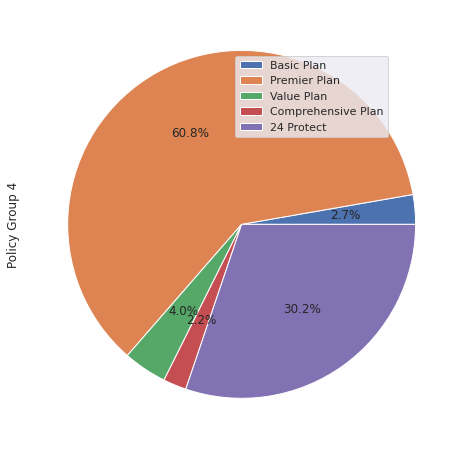

In [222]:
group='Policy Group 4'
data=pd.DataFrame(data=df[df['product_name'].isin(policy_groups[group])][['product_name','agency']].groupby(by='product_name').size(),
                  columns=[group])
#explode = (0.2, 0, 0)
data.plot.pie(y=group,autopct="%.1f%%",use_index=True,figsize=(8,8),labels=None);
#,explode=explode
plt.legend(labels=policy_groups[group],loc='upper right',bbox_to_anchor=(0.85,0.9));
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/PayPal/{group}.jpg')

In [176]:
def agency_map(x):
  if x in ('EPX','CWT','C2B','JZI'):
    return x
  else:
    return 'OTHERS'

df['agency_map']=df['agency'].apply(agency_map)

<Figure size 1440x1440 with 0 Axes>

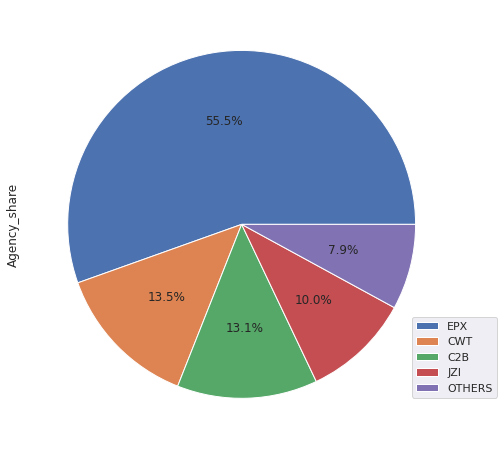

In [178]:
group='Agency'
d=df['agency_map'].value_counts(normalize=True)
data=pd.DataFrame(data={'Agency':d.index,'Agency_share':d.values*100},
                  index=d.index)
#explode = (0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1)
plt.figure(figsize=(20,20));
data.plot.pie(y='Agency_share',use_index=True,figsize=(8,8),labels=None,
                  autopct="%.1f%%",explode=None);
#,explode=explode
plt.legend(labels=d.index,loc='upper right',bbox_to_anchor=(1.1,0.3));
plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/PayPal/{group}.jpg');

In [212]:
df['comm_ratio']=df[['commision_in_value','net_sales']].apply(lambda x:np.abs(np.round((x['commision_in_value']/x['net_sales']),2))*10 if x['net_sales']!=0 else x['commision_in_value'],axis=1)

In [237]:
d=df.groupby(by=['agency','agency_type']).agg({'product_name':['count'],'comm_ratio':['median']})
d.columns = ['_'.join(c).strip('_') for c in d.columns]

In [238]:
d.sort_values(by=['comm_ratio_median'])

,,product_name_count,comm_ratio_median
agency,agency_type,,
EPX,Travel Agency,35119,0.00
TTW,Travel Agency,98,0.00
C2B,Airlines,8267,0.25
SSI,Airlines,1056,0.28
CBH,Travel Agency,101,0.33
CCR,Travel Agency,194,0.33
CSR,Travel Agency,86,0.33
ART,Airlines,331,0.35
JZI,Airlines,6329,0.35


In [215]:
d=df.groupby(by=['agency','product_name']).agg({'agency_type':['count'],'comm_ratio':['median']})
d.columns = ['_'.join(c).strip('_') for c in d.columns]
d

agency_type_count  comm_ratio_median
agency product_name                                                              
ADM    Premier Plan                                         46               3.80
       Value Plan                                           36               3.80
ART    24 Protect                                          247               3.50
       Value Plan                                           84               3.50
C2B    Annual Gold Plan                                    194               2.50
       Annual Silver Plan                                 1423               2.50
       Bronze Plan                                        4049               2.50
       Gold Plan                                           352               2.50
       Silver Plan                                        2249               2.50
CBH    Comprehensive Plan                                   99               3.30
       Premier Plan                                          2               3.30
CCR    Comprehensive Plan                                  181               3.30
       Premier Plan                                         13               3.30
CSR    Comprehensive Plan                                   84               3.30
       Premier Plan                                          2               3.30
CWT    Rental Vehicle Excess Insurance                    8580               6.00
EPX    1 way Comprehensive Plan                           3331               0.00
       2 way Comprehensive Plan                          13158               0.00
       Cancellation Plan                                 18630               0.00
JWT    Value Plan                                          749               4.00
JZI    Basic Plan                                         5469               3.50
       Premier Plan                                          6               3.50
       Value Plan                                          854               3.50
KML    Premier Plan                                        125               3.80
       Value Plan                                          267               3.80
LWC    Annual Travel Protect Gold                          100               6.50
       Annual Travel Protect Platinum                       53               6.50
       Annual Travel Protect Silver                         86               6.50
       Single Trip Travel Protect Gold                     204               6.50
       Single Trip Travel Protect Platinum                  73               6.50
       Single Trip Travel Protect Silver                   173               6.50
RAB    Value Plan                                          725               4.00
SSI    Ticket Protector                                   1056               2.80
TST    Travel Cruise Protect                               527               3.50
       Travel Cruise Protect Family                          1              22.75
TTW    Child Comprehensive Plan                              9               0.00
       Individual Comprehensive Plan                        74               0.00
       Spouse or Parents Comprehensive Plan                 15               0.00

#### Feature Engineering

In [240]:
df.columns=df.columns.map(lambda x:'_'.join(x.lower().replace('(','').replace(')','').split(' ')))

numerical_feature_list=list(df.select_dtypes(exclude='object').columns)
categorical_feature_list=list(df.select_dtypes(include='object').columns)

target='claim'

# Function to get the distribution of data for each feature
# This can be used for categorical features
def frequency_encoding(column_name,output_column_name,df):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])

def feature_engineering(df):
        
    #Interaction Feature (Combining 2 categorical features and performing frequency encoding)
    
    cat_columns=categorical_feature_list[:]
    num_columns=numerical_feature_list[:]
    #cat_columns.remove(target)
    derived_cat_features_list=[]

    comb = combinations(cat_columns, 2) 
    cat_agg_list=['nunique','count']
    num_agg_list=['mean','median', 'max', 'min','std']

    # Impute NaN in gender feature to value
    df['gender'].fillna(value='X',inplace=True)

    # Lets get absolute values and see if that helps
    #df['net_abs_sales']=np.abs(df['net_sales'])
    #numerical_feature_list.append('net_abs_sales')

    #Frequency Encoding
    for i in cat_columns:
      frequency_encoding(i,f'{i}_fe',df)
      derived_cat_features_list.append(f'{i}_fe')
    
    for i in list(comb):  
        df[f'{i[0]}_{i[1]}']=df[i[0]].astype(str)+'_'+df[i[1]].astype(str)
        frequency_encoding(f'{i[0]}_{i[1]}',f'{i[0]}_{i[1]}',df)
        derived_cat_features_list.append(f'{i[0]}_{i[1]}')

    df['comm_ratio']=df[['commision_in_value','net_sales']].apply(lambda x:np.abs(np.round((x['commision_in_value']/x['net_sales']),2))*10 if x['net_sales']!=0 else x['commision_in_value'],axis=1)
    num_columns.append('comm_ratio')

    agg_dict=dict()
    for i in cat_columns:
      agg_dict[i]=dict()
      for j in cat_columns+num_columns:
        if i!=j:
           agg_dict[i][j]= cat_agg_list if j in cat_columns else num_agg_list
      d=df.groupby(by=i).agg(agg_dict[i])
      d.columns= [f'{i}_'+'_'.join(k) for k in d.columns]
      df = pd.merge(df, d, on = [i], how='left')
    

    comb=[['agency','product_name'],['agency','product_name','destination']]

    agency_prodnm_nuniq_agg_features=df.groupby(by=['agency_product_name_nunique']).agg({'net_sales':num_agg_list,
                                                                                  'duration':num_agg_list,
                                                                                  'age':num_agg_list,
                                                                                  'commision_in_value':num_agg_list,
                                                                                  'comm_ratio':num_agg_list,
                                                                                  'destination':cat_agg_list,
                                                                                  'gender': cat_agg_list
                                                                                 })
    
    agency_prodnm_nuniq_agg_features.columns = ['agency_prodnm_nuniq_agg_' + '_'.join(c) for c in agency_prodnm_nuniq_agg_features.columns]
    df = pd.merge(df, agency_prodnm_nuniq_agg_features, on = ['agency_product_name_nunique'], how='left')

    agency_productname_agg_features=df.groupby(by=['agency','product_name']).agg({'net_sales':num_agg_list,
                                                                                  'duration':num_agg_list,
                                                                                  'age':num_agg_list,
                                                                                  'commision_in_value':num_agg_list,
                                                                                  'comm_ratio':num_agg_list,
                                                                                  'destination':cat_agg_list,
                                                                                  'gender': cat_agg_list
                                                                                 })
    
    agency_productname_agg_features.columns = ['agency_productname_agg_' + '_'.join(c) for c in agency_productname_agg_features.columns]
    df = pd.merge(df, agency_productname_agg_features, on = ['agency','product_name'], how='left')

    agency_prodnm_dest_agg_features=df.groupby(by=['agency','product_name','destination']).agg({'net_sales':num_agg_list,
                                                                                                'duration':num_agg_list,
                                                                                                'age':num_agg_list,
                                                                                                'commision_in_value':num_agg_list,
                                                                                                'comm_ratio':num_agg_list,
                                                                                                'gender': cat_agg_list
                                                                                               })
    
    agency_prodnm_dest_agg_features.columns = ['agency_prodnm_dest_agg_' + '_'.join(c) for c in agency_prodnm_dest_agg_features.columns]
    df = pd.merge(df, agency_prodnm_dest_agg_features, on = ['agency','product_name','destination'], how='left')


    #Creating Bins and deriving characteristics of each group by creating aggregate features
    bins = KBinsDiscretizer(encode='ordinal', strategy='quantile')
    for i in numerical_feature_list:
        df[f'{i}_bin'] =bins.fit_transform(df[i].values.reshape(-1,1)).astype(int)
        derived_cat_features_list.append(f'{i}_bin')
        frequency_encoding(f'{i}_bin',f'{i}_fe',df)
        derived_cat_features_list.append(f'{i}_fe')

    agency_productnm_destination_agg_features=df.groupby(by=['agency','product_name','destination','age_bin']).agg({'duration':num_agg_list,
                                                                                                  'commision_in_value':num_agg_list,
                                                                                                  'comm_ratio':num_agg_list,
                                                                                                  'net_sales':num_agg_list,
                                                                                                  'gender': cat_agg_list
                                                                                                 })
    
    agency_productnm_destination_agg_features.columns = ['agency_productnm_destination_agg_' + '_'.join(c) for c in agency_productnm_destination_agg_features.columns]
    df = pd.merge(df, agency_productnm_destination_agg_features, on = ['agency','product_name','destination','age_bin'], how='left')

    agency_prodnm_duration_agg_features=df.groupby(by=['agency','product_name','duration_bin']).agg({'net_sales':num_agg_list,
                                                                                  'age':num_agg_list,
                                                                                  'commision_in_value':num_agg_list,
                                                                                  'comm_ratio':num_agg_list,
                                                                                  'destination':cat_agg_list,
                                                                                  'gender': cat_agg_list
                                                                                 })
    
    agency_prodnm_duration_agg_features.columns = ['agency_prodnm_duration_agg_' + '_'.join(c) for c in agency_prodnm_duration_agg_features.columns]
    df = pd.merge(df, agency_prodnm_duration_agg_features, on = ['agency','product_name','duration_bin'], how='left')

    return df
    

In [241]:
df=feature_engineering(df)

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.


#### Data Preparation

In [242]:
seed=7
def training_dataprep(df):
    
    le = LabelEncoder()
    for col in categorical_feature_list:
        df[col]=  df[col].astype('str')
        df[col]= le.fit_transform(df[col])
    X=df
    y=df[target]

    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=seed,test_size=0.3,stratify=y)
    
    drop_columns=[i for i in df.columns if ('bins' in i) or (target in i)]
    #drop_columns=[i for i in df.columns if (target in i)]

    X_train=X_train.drop(columns=drop_columns,axis=1)
    X_test=X_test.drop(columns=drop_columns,axis=1)
    X_train.reset_index(drop=True,inplace=True)
    y_train.reset_index(drop=True,inplace=True)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    return X_train,X_test,y_train,y_test

In [243]:
X_train,X_test,y_train,y_test=training_dataprep(df)

(44328, 381)
(44328,)
(18998, 381)
(18998,)


#### Model Build:

In [244]:
shap_values_list=[]

def xgb_model(df):
    
    X,X_test,y,y_test=training_dataprep(df)
    
    params={'lambda': 1.1, 
        'alpha': 0.1, 
        'colsample_bytree': 0.9, 
        'subsample': 0.7, 
        'learning_rate': 0.01,
        'max_depth': 6, 
        'random_state': seed, 
        #'min_child_weight': 5,
        'scale_pos_weight':60}
    
    err = [] 
    oofs = np.zeros(shape=(len(X)))
    preds = np.zeros(shape=(len(X_test)))

    Folds=5

    fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=seed)
    i = 1

    for train_index, val_index in fold.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
        m = XGBClassifier(n_estimators=1000,**params)
    
        m.fit(X_train, y_train,eval_set=[(X_val, y_val)], early_stopping_rounds=30,verbose=False,eval_metric='auc')
    
        y_val_pred = m.predict_proba(X_val)[:,1]
        oofs[val_index] = y_val_pred
        print(i, " err_xgb: ", roc_auc_score(y_val,y_val_pred))
        err.append(roc_auc_score(y_val,y_val_pred))
        preds+= m.predict_proba(X_test)[:,1]
        shap_values_list.append(shap.TreeExplainer(m).shap_values(X_train))

        #fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
        #roc_auc = auc(fpr, tpr)

        #plt.title('Receiver Operating Characteristic')
        #plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
        #plt.legend(loc='lower right')
        #plt.plot([0,1],[0,1],'r--')
        #plt.xlim([-0.001, 1])
        #plt.ylim([0, 1.001])
        #plt.ylabel('True Positive Rate')
        #plt.xlabel('False Positive Rate')
        #plt.show();
        i = i + 1
    preds=preds/Folds
    print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
    oof_score = roc_auc_score(y, oofs)
    print(f'\nOOF Auc is : {oof_score}')
    print(f'\nAUC for Test: {roc_auc_score(y_test,preds)}')

    oofs=pd.DataFrame(oofs,columns=['xgboof'])
    preds=pd.DataFrame(preds,columns=['xgbpred'])
    
    oofs.to_csv('xgboof.csv',index=False)
    preds.to_csv('xgbpred.csv',index=False)

    return m

In [245]:
m=xgb_model(df)

(44328, 381)
(44328,)
(18998, 381)
(18998,)
1  err_xgb:  0.7911528775711468
2  err_xgb:  0.8188402542969851
3  err_xgb:  0.8231627747252748
4  err_xgb:  0.8074300941306756
5  err_xgb:  0.8154202809211395
Average StratifiedKFold Score : 0.8112012563290444 

OOF Auc is : 0.7872798439067534

AUC for Test: 0.8461267524441985


In [246]:
y_train_pred=m.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_train_pred)

0.8716126979179348

In [247]:
y_test_pred=m.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_test_pred)

0.8366917043288447

In [248]:
d=pd.DataFrame(data=m.feature_importances_,index=X_train.columns)
d[0].sort_values(ascending=False)[:10]

agency_net_sales_mean                              0.169921
product_name_age_max                               0.151688
agency_product_name_nunique                        0.146181
agency_productname_agg_duration_median             0.035874
product_name_duration_mean                         0.023274
agency_prodnm_dest_agg_net_sales_max               0.013445
agency_productnm_destination_agg_net_sales_mean    0.010833
agency_prodnm_duration_agg_net_sales_median        0.010640
agency_prodnm_duration_agg_net_sales_mean          0.008932
agency_productname_agg_duration_mean               0.008668
Name: 0, dtype: float32

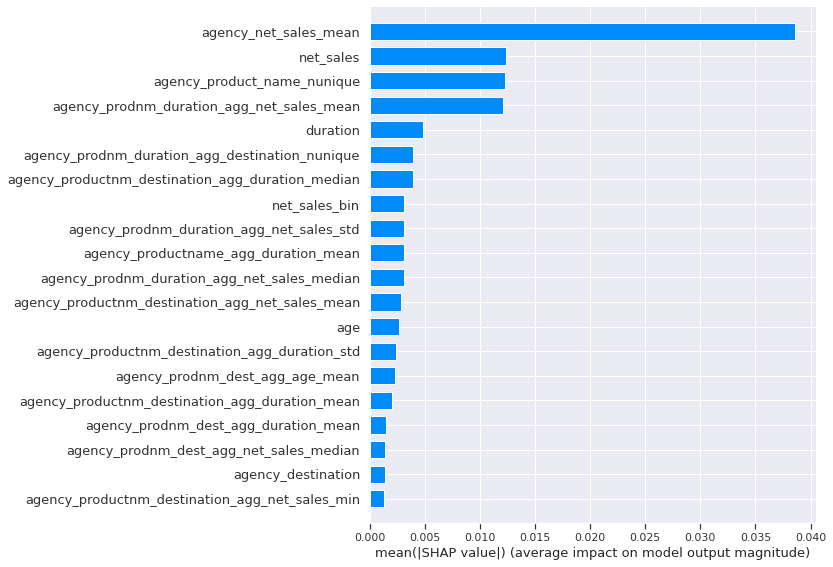

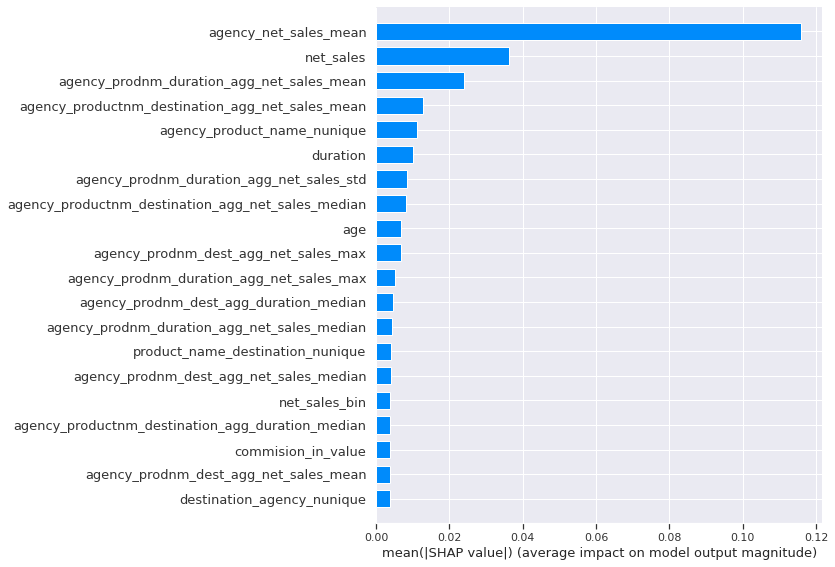

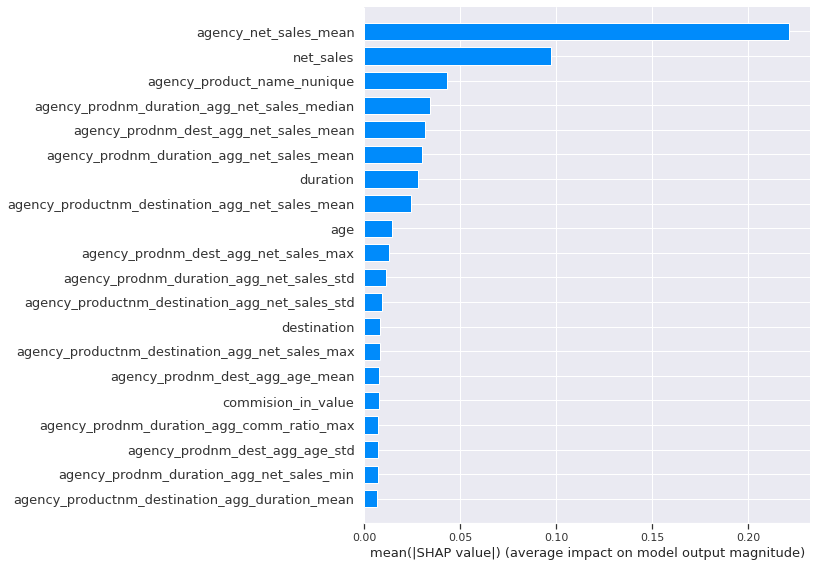

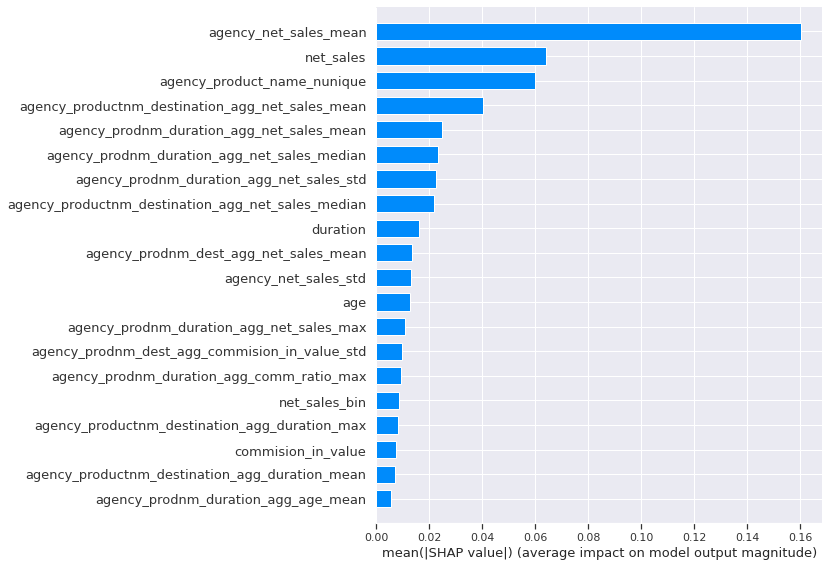

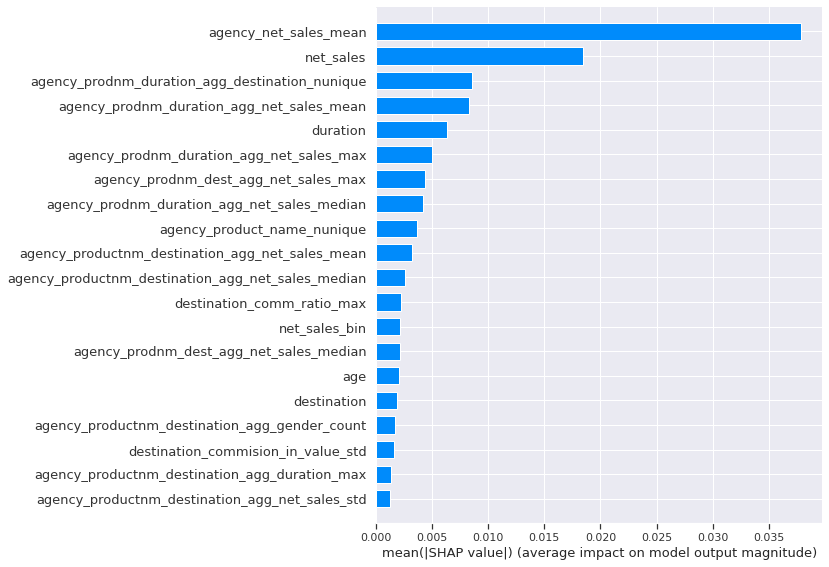

In [249]:
for i in shap_values_list:
  shap.summary_plot(i, X_train, plot_type="bar")